# Preparation For Topic Modelling

Eventually to include tf-idf threshold

In [2]:
import os
import pandas as pd
from nltk import word_tokenize, wordpunct_tokenize
from nltk.stem import PorterStemmer
from gensim.corpora import Dictionary
import string
import utils
import math
import matplotlib.pyplot as plt

In [5]:
# sdf = pd.read_csv('transcripts/speeches.csv')
tdf = pd.read_csv('working-csvs/raw_transcripts.csv', index_col=0)

A function to eliminate utterances less than 5 words long. Not currently sure if I will use this. I would if I was replicating Shapiro Wilson 2021, but that is no longer the plan. Keeping it around for now.

In [1]:
def long_enough(text):
    cleaned_tokens = [token for token in word_tokenize(str(text)) if token not in string.punctuation]
    if len(cleaned_tokens) < 5:
        return False
    return True

In [4]:
tdf_filtered = tdf[tdf.content.apply(long_enough) == True]

In [5]:
tdf_filtered = tdf_filtered.reset_index().drop('level_0', axis=1)

Another idea from Shapiro and Wilson, which I don't know if I will use. The idea is to remove "stand alone utterances" where the speakers of the utterances before and after is different. In practice, I don't know how useful this is. It is possible I am misinterpreting their meaning. Either way, for now I am not using this but I'm leaving it around for now.

In [6]:
def check_bef_aft_speakers(row):
    row_ind = row.name
    # print(row_ind)
    if row_ind == 0 or row_ind == len(tdf) - 1:
        return True
    if tdf.loc[row_ind].date != tdf.loc[row_ind + 1].date:
        return True
    prev_speaker = tdf.loc[row_ind - 1].speaker
    next_speaker = tdf.loc[row_ind + 1].speaker
    curr_speaker = tdf.loc[row_ind].speaker

    print('---------')
    print(row.content)
    print(prev_speaker)
    print(curr_speaker)
    print(next_speaker)

    if curr_speaker != prev_speaker and curr_speaker != next_speaker and prev_speaker != next_speaker:
        print('get rid')
        return False
    return True

In [7]:
# tdf_filtered['test'] = tdf_filtered.apply(check_bef_aft_speakers, axis=1)

In [8]:
tdf_filtered

,speaker,content,index,date,type
0,CHAIR YELLEN.,"Good morning, everybody. As you know, we had ...",0,2015-03-18,meeting
1,CHAIR YELLEN.,Thank you. Without objection. I am going to ...,2,2015-03-18,meeting
2,MR. POTTER.,"Thank you, Madam Chair. We will be splitting t...",3,2015-03-18,meeting
3,MR. KOCHERLAKOTA.,"Yes. Actually, it is more of a comment than a ...",5,2015-03-18,meeting
4,MR. POTTER.,"In the past week, that is true. The TIPS break...",6,2015-03-18,meeting
...,...,...,...,...,...
37005,CHAIRMAN BERNANKE.,"Thank you very much. Thank you, all, for bear...",373,2012-03-13,meeting
37006,MR. LACKER.,Earlier in the meeting about today's statement...,374,2012-03-13,meeting
37007,CHAIRMAN BERNANKE.,"Well, I asked for discussion of that point tod...",375,2012-03-13,meeting
37008,CHAIRMAN BERNANKE.,And I was very clear that that is certainly no...,377,2012-03-13,meeting


## Bi and Trigram enhancements

In [6]:
bigrams = set()

with open(os.path.join('ngrams', 'bigrams')) as bg_file:
    for bg in bg_file.readlines():
        bigrams.add(bg.strip())

In [7]:
trigrams = set()

with open(os.path.join('ngrams', 'trigrams')) as tg_file:
    for tf in tg_file.readlines():
        trigrams.add(tf.strip())

In [8]:
def ngram_enhance(raw_string):
    to_add = []
    raw_string = str(raw_string)
    for bg in bigrams:
        if str(bg) in raw_string.lower():
            to_add.append('_'.join(bg.split(' ')))
    for tg in trigrams:
        if str(tg) in raw_string.lower():
            to_add.append('_'.join(tg.split(' ')))

    return raw_string + ' ' + ' '.join(to_add)

In [9]:
# sdf['text_enhanced'] = sdf['text'].apply(ngram_enhance)
tdf['text_enhanced'] = tdf['content'].apply(ngram_enhance)

In [10]:
tdf.to_csv('working-csvs/transcripts_enhanced.csv')

In [ ]:
# sdf.to_csv('speeches_enhanced.csv')

## Create Speaker-Meeting observations

In [11]:
tdf_e = pd.read_csv('working-csvs/transcripts_enhanced.csv')

In [12]:
tdf_e['type'].value_counts()

type
meeting     86326
confcall     4383
Name: count, dtype: int64

In [13]:
tdf_e = tdf_e[tdf_e['type'] == 'meeting']

In [14]:
stemmer = PorterStemmer()

In [15]:
tdf_e['tokens'] = tdf_e['text_enhanced'].apply(lambda x : utils.process(x, stemmer=stemmer)) 

In [16]:
texts = tdf_e['tokens'].tolist()
dictionary = Dictionary(texts)
len(dictionary)

18541

In [17]:
count = 0

freqs = {}
doc_appears = {}

for text in texts:
    for token, freq in dictionary.doc2bow(text):
        if token in freqs:
            freqs[token] += freq
        else:
            freqs[token] = freq
        if token in doc_appears:
            doc_appears[token] += 1
        else:
            doc_appears[token] = 1
    count +=1

In [18]:
idf = {i: math.log(len(texts) / doc_appears[i]) for i in range(len(dictionary))}
tfidf_global = {i: idf[i] * (1 + math.log(freqs[i])) for i in range(len(dictionary))}
tfidf_vals = sorted([rank for rank in tfidf_global.values()], reverse=True)

In [19]:
dictionary.doc2bow(['growth', 'product'])

[(13, 1), (228, 1)]

In [20]:
tfidf_global[228]

25.763753301507016

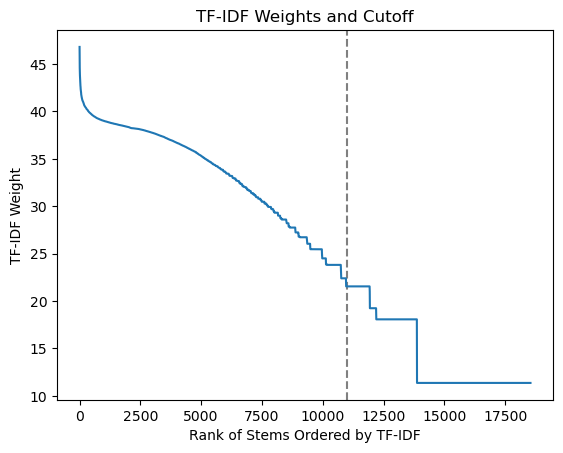

In [31]:
fig, ax = plt.subplots()

ax.set_title('TF-IDF Weights and Cutoff')

ax.axvline(x=11000, color='gray', linestyle='--')
ax.set_xlabel('Rank of Stems Ordered by TF-IDF')
ax.set_ylabel('TF-IDF Weight')

ax.plot(tfidf_vals)

In [38]:
tfidf_vals[11000]

21.54702700484636

In [39]:
tokens_to_keep = [i for i, tfidf in tfidf_global.items() if tfidf > tfidf_vals[11000]]
len(tokens_to_keep)

10957

In [40]:
dictionary.filter_tokens(good_ids=tokens_to_keep)
dictionary.compactify()
len(dictionary)

10957

EVENTUALLY FIX TO FILTER OUT PRE 1994 FROM DICT CREATION

In [45]:
dictionary.save('12-10dict')

In [48]:
speaker_grouped = tdf_e.groupby(['date', 'speaker'])['text_enhanced'].agg(' '.join).reset_index()

In [49]:
speaker_grouped.to_csv('working-csvs/speaker_grouped.csv')